#**Classifying AI-Generated and Real Shoe Images with Deep Learning**
### Submitted by :
- Rameen Jamshed | FA22-BAI-034
- Alisha Ghaiyas | FA22-BAI-006

#Introduction

In this project, we have developed a deep learning model for image classification using the ResNet18 architecture. The objective is to classify images of shoes into two categories: AI-generated (using Midjourney) and real images. This model leverages a pre-trained ResNet18 network, fine-tuned to distinguish between the two classes effectively.

#Model Details

###ResNet18 Architecture:

ResNet18 is a deep convolutional neural network known for its residual learning framework, which helps in training very deep networks by addressing the vanishing gradient problem. This model was pre-trained on a large dataset (ImageNet) and fine-tuned for our specific task.

###Data Augmentation:

The training data undergoes several transformations, including random horizontal flipping, random rotations, color jitter, and normalization. These augmentations help the model generalize better by simulating various real-world conditions.

###Custom Head:

The final fully connected layer of ResNet18 was replaced with a new layer suited for binary classification (two classes: AI-generated and real).

###Training and Validation:

The model is trained using PyTorch Lightning, which simplifies the training loop and handles GPU acceleration efficiently. The training and validation datasets are split in an 80:20 ratio, respectively.

###Evaluation Metrics:

We track training loss, validation loss, and validation accuracy to monitor the model’s performance. The training process includes checkpoints and learning rate scheduling to optimize training efficiency and accuracy.

#Downloading Dependencies

In [2]:

!pip install pytorch_lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 37.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

#Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as F

from fastai.vision.all import *
from torchvision import transforms, datasets, models
from torch.utils.data import random_split
from torchmetrics.functional import accuracy
from torch.optim.lr_scheduler import MultiplicativeLR

# Ensure compatibility with Colab
import requests
import zipfile
import os

# Download and extract the dataset
download_url = "https://www.kaggle.com/api/v1/datasets/download/sunnykakar/shoes-dataset-real-and-ai-generated-images?datasetVersionNumber=2"
zip_file_path = "/content/shoes_dataset.zip"  # Update path for Colab
extract_folder = "/content/shoes_dataset"  # Update path for Colab

response = requests.get(download_url, stream=True)
with open(zip_file_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=128):
        file.write(chunk)

with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

# Define the dataset path
path = '/content/shoes_dataset'  # Update this path with the actual path to your dataset in Colab




#Loading Dataset

In [4]:
ds = datasets.ImageFolder(path)

In [5]:
gen1 = torch.Generator().manual_seed(322)


*torch.Generator()* creates a random number generator (RNG) object using the default settings provided by PyTorch and we set the seed of the RNG is to 322. By fixing the seed, you ensure that the sequence of random numbers generated by the RNG will be the same every time the code is run, given the same initial conditions. This makes the results of the experiments deterministic, allowing for easier debugging and comparison between different runs.

In [6]:
ds.classes, len(ds)


(['ai-midjourney', 'real'], 2181)

So, here we see that we have two labels in our dataset i.e. *'ai-midjourney'* and *real*. Total number of images are 2181.

#Data Preprocessing

In [7]:
train_ds, test_ds = random_split(ds, [0.8, 0.2], gen1)


Here we split the dataset into two parts, test_ds, and train_ds, in the ratio 20/80.

20 -> test_ds

80 -> train_ds

In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



For the train_transform set of transformations:

**RandomHorizontalFlip:**

Randomly flips the input images horizontally with a probability of 0.5. This augmentation technique increases the diversity of the training data by simulating different viewpoints.

**RandomRotation:**

Randomly rotates the input images by a maximum angle of 0.2 radians (approximately 11.5 degrees) in either clockwise or counterclockwise direction. This augmentation helps the model become more robust to variations in object orientation.

**ColorJitter:**

Randomly adjusts the brightness, contrast, saturation, and hue of the input images. This augmentation introduces variations in color and lighting conditions, making the model more tolerant to changes in illumination.

**ToTensor:**

Converts the input images from PIL Image format to PyTorch tensor format. This transformation is necessary as PyTorch models operate on tensors.

**Normalize:**

Normalizes the pixel values of the input images. It subtracts mean values [0.485, 0.456, 0.406] and divides by standard deviation values [0.229, 0.224, 0.225] along each channel. Normalization standardizes the input data, facilitating faster convergence during model training.

In [9]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

For the test_transform set of transformations:

**ToTensor:**

Converts the input images from PIL Image format to PyTorch tensor format.

**Normalize:**

Normalizes the pixel values of the input images using the same mean and standard deviation values as the training set. This ensures consistency between the training and testing data, enabling the model to generalize better to unseen images.

In [10]:
class TransformWrapper:
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = self.transform(image)
        return image, label


###The TransformWrapper class

It is a custom wrapper designed to apply transformations to a given dataset. It encapsulates both the original dataset and the transformation functions to preprocess the data.

**__init__(self, dataset, transform):** The constructor method initializes the TransformWrapper object with two main attributes:

**dataset:** Represents the original dataset containing images and labels.
transform: Represents the transformation function or pipeline that will be applied to each image in the dataset.

**__len__(self):** This method returns the length of the dataset, which is defined as the number of samples in the original dataset. It allows other functions to access the length of the transformed dataset conveniently.

**__getitem__(self, idx):** This method enables the class instance to behave like a list or iterable. Given an index idx, it retrieves the image and corresponding label from the original dataset at that index. Then, it applies the specified transformation (self.transform) to the image. Finally, it returns the transformed image along with its label.

In [11]:
train_dataset = TransformWrapper(train_ds, train_transform)
test_dataset = TransformWrapper(test_ds, test_transform)

These instances encapsulate both the datasets and their respective transformation pipelines, providing a convenient way to access the transformed images and labels during training and testing stages.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**train_loader:**

It prepares batches of training data. Each batch contains 32 images along with their corresponding labels. The shuffle=False argument means the order of images in the dataset is not changed between epochs (passes through the dataset).

**test_loader:**

Similarly, this prepares batches of testing data. Again, each batch contains 32 images. Like the training loader, the testing loader also does not shuffle the data, ensuring consistent evaluation.

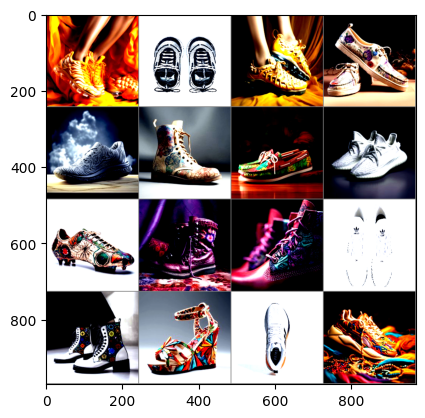

In [13]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def imshow(img):

    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(vutils.make_grid(images[:16], nrow=4))

The output grid displays a set of images arranged in rows and columns.

- Each row contains four images, as specified by the nrow=4 argument in vutils.make_grid.

- The pixel values of the images are rescaled and transformed to ensure they are within the range [0, 1] before being displayed.

- The grid provides a visual representation of a subset of the training dataset, making it easier to inspect and understand the images in the dataset.







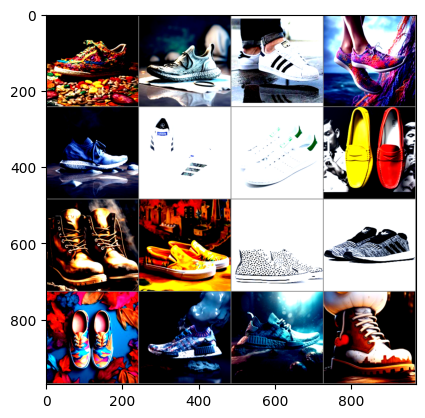

In [14]:
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)

imshow(vutils.make_grid(images[:16], nrow=4))

#Convolutional Neural Network (CNN):  **ResNet18.**

In [15]:
model = models.resnet18(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


It creates a ResNet-18 model instance with default weights. ResNet-18 is a convolutional neural network architecture designed for image classification tasks. The 'DEFAULT' argument specifies that the pre-trained weights should be used, which are typically trained on the ImageNet dataset.

In [16]:
num_features = model.fc.in_features


It retrieves the number of input features of the fully connected (fc) layer of the ResNet-18 model. This value corresponds to the number of output channels of the last convolutional layer before the fully connected layer.



In [17]:
model.fc = torch.nn.Linear(num_features, 2)

- It replaces the fully connected layer (model.fc) of the ResNet-18 model with a new linear layer (torch.nn.Linear) that outputs two classes.
- The num_features is used as the number of input features for the new linear layer, ensuring compatibility with the output of the ResNet-18 backbone.
- The output size of 2 indicates that the model is being adapted for a binary classification task, where there are two classes to predict.

In [18]:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4[1].parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True


In this code snippet, we are iterating through the parameters of the model object. Initially, we set requires_grad to False for all parameters, effectively freezing them to prevent them from being updated during training.

Next, we focus on the parameters of the second residual block (layer4[1]) of the ResNet-18 model. We set requires_grad to True for these parameters, allowing them to be updated during training.

Finally, we target the parameters of the fully connected layer (model.fc) and also set requires_grad to True, enabling them to be trained along with the rest of the model. This step is necessary because we replaced the last fully connected layer with a new one tailored to our binary classification task.

In [19]:
class LitModel(pl.LightningModule):

    def __init__(self, model):
        super().__init__()
        self.model = model
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.accuracy_outputs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = F.cross_entropy(logits, labels)

        if batch_idx % 4 == 0:
            self.training_step_outputs.append(loss.item())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):

        images, labels = batch
        outputs = self.model(images)
        loss = F.cross_entropy(outputs, labels)
        self.validation_step_outputs.append(loss.item())

        acc = accuracy(torch.argmax(outputs, 1), labels, task='binary')
        self.accuracy_outputs.append(acc.item())

        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics)
        return metrics
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=0.0002)
        lr_scheduler = MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch'
            }
        }

    def train_dataloader(self):
        return train_loader

    def test_dataloader(self):
        return test_loader

This class, LitModel, is a PyTorch Lightning module used for training and evaluating a neural network model for image classification.

**Initialization:** It takes a neural network model as input and initializes necessary attributes for tracking training and validation metrics.

**Forward Pass:** Implements the forward pass method, which applies the model to input data to generate predictions.

**Training Step:** Defines the training step, where it computes the loss using cross-entropy loss and logs it. It also tracks the loss outputs every 4 batches.

**Validation Step:** Defines the validation step, where it computes the loss and accuracy metrics using cross-entropy loss and accuracy functions. It logs these metrics and returns them for evaluation.

**Optimizer Configuration:** Configures the optimizer (AdamW) with a specific learning rate and a scheduler (MultiplicativeLR) to adjust the learning rate during training.

**Data Loaders:** Provides methods to access the training and testing data loaders.

##Model Training

This snippet trains the LitModel instance using PyTorch Lightning's Trainer. It specifies a maximum of 5 epochs for training and fits the model using the provided training and validation data loaders (train_loader and test_loader, respectively).

In [20]:
from pytorch_lightning import Trainer

model = LitModel(model)
trainer = Trainer(max_epochs=5)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
4.7 M     Trainable params
6.5 M     Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


#Model Accuracy

###Training and Validation Losses

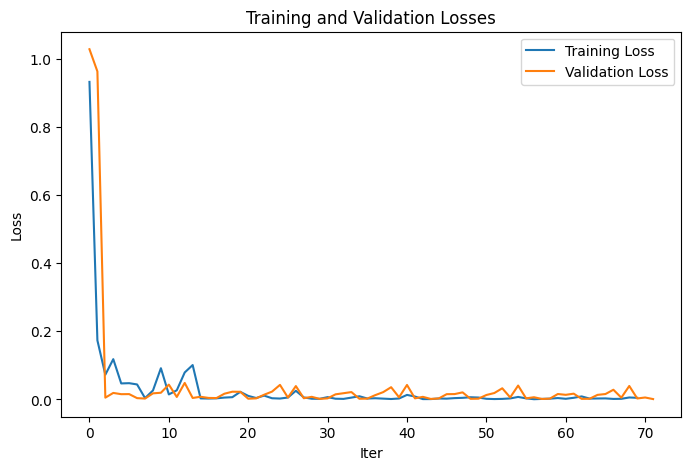

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(model.training_step_outputs, label='Training Loss')
plt.plot(model.validation_step_outputs, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.legend()
plt.show()

The output of this code is a plot visualizing the training and validation loss trends throughout the training process. The x-axis represents the number of iterations or epochs, while the y-axis represents the corresponding loss values. The plot allows us to observe how the loss changes over time and compare the performance of the model on both the training and validation datasets.

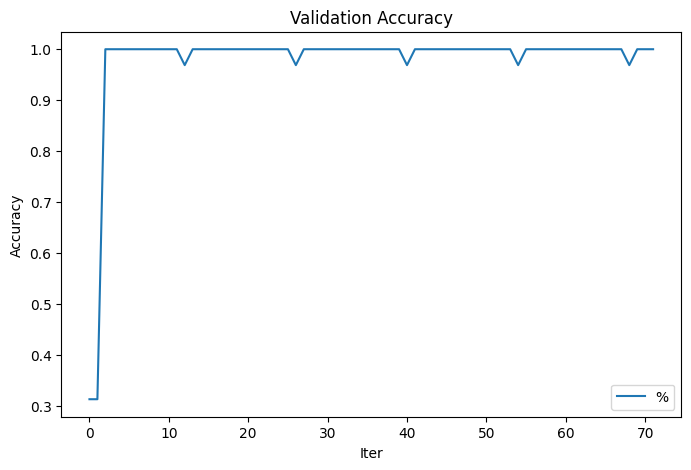

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(model.accuracy_outputs, label='%')
plt.title('Validation Accuracy')
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

###Validation Accuracy

Validation accuracy is a measure of how well the model performs on a separate validation dataset that was not used during the training process. It is the percentage of correctly predicted samples out of the total validation samples. Validation accuracy helps assess how well the model generalizes to unseen data. Here’s why it’s important and how it is used:

#Feature Importance Visualization

In our project on image classification with ResNet18, we employed Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the important features identified by the model during its training process. Grad-CAM is a technique used to interpret and understand the decisions made by convolutional neural networks (CNNs) by highlighting the regions of an input image that were influential in making a particular prediction.

In [23]:
!pip install torchcam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.4 MB/s eta 0:00:00


In [24]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image


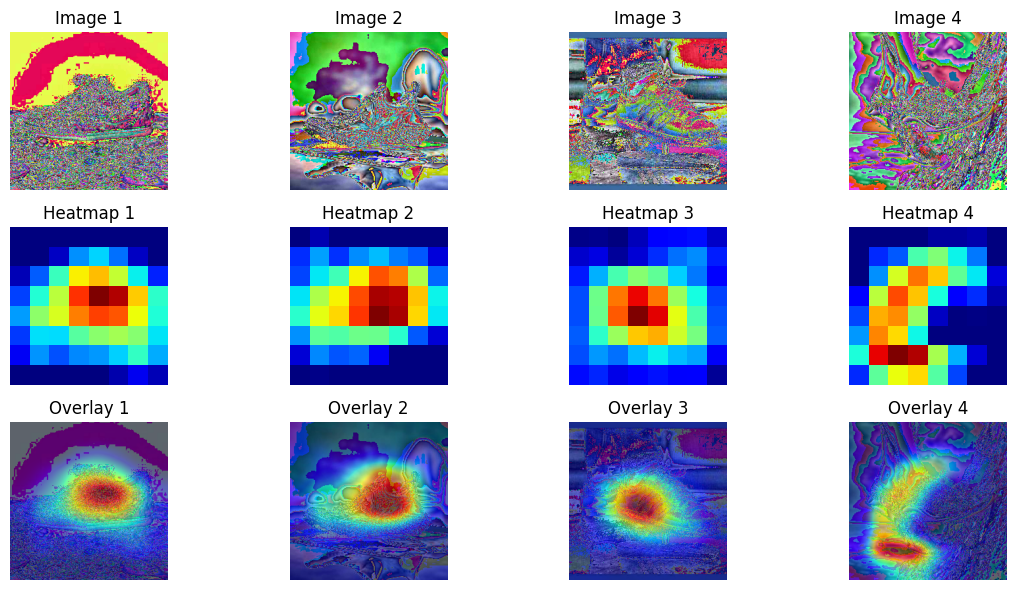

In [37]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Correctly target the last convolutional layer
layer_name = 'layer4.1.conv2'

# Create the GradCAM object for the identified convolutional layer
cam_extractor = GradCAM(model.model, target_layer=layer_name)

def visualize_feature_importance(model, dataloader, cam_extractor, num_images=4):
    # Set the model to evaluation mode
    model.eval()

    # Get a batch of images and labels from the dataloader
    images, labels = next(iter(dataloader))
    images, labels = images[:num_images], labels[:num_images]  # Select a subset of images for visualization

    # Forward pass through the model to hook the convolutional features
    outputs = model(images)
    predicted_classes = torch.argmax(outputs, dim=1)

    # Generate the Grad-CAM heatmaps
    cams = []
    for image, pred_class in zip(images, predicted_classes):
        # Perform a forward pass to get the model output scores
        scores = model(image.unsqueeze(0))
        # Extract the CAM for the predicted class
        cam = cam_extractor(class_idx=[pred_class.item()], scores=scores)
        cams.append(cam)

    # Plot the images and their corresponding Grad-CAM heatmaps
    plt.figure(figsize=(12, 6))
    for i, (image, cam) in enumerate(zip(images, cams)):
        # Convert the image to a PIL image
        pil_image = to_pil_image(image.cpu())

        # Get the heatmap and squeeze it to remove single-dimension entries
        heatmap = cam[0].squeeze().cpu().detach().numpy()

        # Overlay the Grad-CAM heatmap on the image
        result = overlay_mask(pil_image, to_pil_image(heatmap, mode='F'), alpha=0.4)

        # Plot the original image, Grad-CAM heatmap, and overlay
        plt.subplot(3, num_images, i+1)
        plt.imshow(pil_image)
        plt.axis('off')
        plt.title(f"Image {i+1}")

        plt.subplot(3, num_images, num_images+i+1)
        plt.imshow(heatmap, cmap='jet')
        plt.axis('off')
        plt.title(f"Heatmap {i+1}")

        plt.subplot(3, num_images, 2*num_images+i+1)
        plt.imshow(result)
        plt.axis('off')
        plt.title(f"Overlay {i+1}")

    plt.tight_layout()
    plt.show()

# Visualize feature importance using Grad-CAM
visualize_feature_importance(model, test_loader, cam_extractor, num_images=4)


##The process of utilizing Grad-CAM for important feature visualization:

###Model Training:

We trained a ResNet18 model for image classification tasks. ResNet18 is a deep CNN architecture commonly used for various computer vision tasks due to its effectiveness in feature extraction and classification.

###Prediction:

After training the ResNet18 model, we utilized it to make predictions on a dataset of images. The model analyzed each image and produced a prediction indicating the most likely class or category for that image.

###Grad-CAM Computation:

Following the model's prediction, Grad-CAM was applied to visualize the important features that influenced the model's decision-making process. Grad-CAM computes the gradients of the predicted class score with respect to the feature maps of the last convolutional layer in the model.

###Heatmap Generation:

By weighting the feature maps with the computed gradients, Grad-CAM generates a heatmap that highlights the regions of the input image that contributed most significantly to the predicted class. These heatmaps provide insights into which parts of the image the model focused on when making its predictions.

###Overlaying Heatmaps:

The Grad-CAM heatmaps are then overlaid on the original input images. This overlay process visually represents the importance of different features in the input images, allowing for a qualitative understanding of the model's decision-making process.

###Analysis and Interpretation:

By analyzing the overlaid images and heatmaps, we gained insights into the specific regions of the input images that were most relevant for the model's predictions. This analysis provided valuable information about the features and patterns that the model deemed important for distinguishing between different classes or categories.
